In [2]:
import mira
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import logging
logging.getLogger().setLevel(logging.INFO)
mira.utils.wide_view() # set the notebook to wide view

ModuleNotFoundError: No module named 'mira'

In [2]:
mira.datasets.MouseBrainDataset()

data = sc.read_h5ad('mira-datasets/e18_10X_brain_dataset/e18_mouse_brain_10x_dataset.ad')

INFO:mira.datasets.datasets:Dataset contents:
	* mira-datasets/e18_10X_brain_dataset
		* e18_mouse_brain_10x_main_barcodes.csv
		* e18_mouse_brain_10x_atac_model.pth
		* e18_mouse_brain_10x_dataset.ad
		* e18_mouse_brain_10x_rna_model.pth


In [3]:
rna_data = data[:, data.var.feature_types == 'Gene Expression']
atac_data = data[:, data.var.feature_types == 'Peaks']

In [4]:
# Basic preprocessing steps
rna_data.var.index = rna_data.var.index.str.upper()
rna_data.var_names_make_unique()
rna_data = rna_data[:, ~rna_data.var.index.str.startswith('GM')]

sc.pp.filter_cells(rna_data, min_counts = 400)
sc.pp.filter_genes(rna_data, min_cells=15)

rna_data.var['mt'] = rna_data.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(rna_data, qc_vars=['mt'], percent_top=None,
                           log1p=False, inplace=True)

rna_data = rna_data[rna_data.obs.pct_counts_mt < 15, :]
rna_data = rna_data[rna_data.obs.n_genes_by_counts < 8000, :]
sc.pp.filter_genes(rna_data, min_cells=15)

rna_data.raw = rna_data # save raw counts
sc.pp.normalize_total(rna_data, target_sum=1e4)
sc.pp.log1p(rna_data)

sc.pp.highly_variable_genes(rna_data, min_disp = -0.1)
rna_data.layers['norm'] = rna_data.X # save normalized count data
rna_data.X = rna_data.raw.X # and reload raw counts
rna_data = rna_data[:, rna_data.var.highly_variable]
rna_data.var['exog_feature'] = rna_data.var.highly_variable # set column "exog_features" to all genes that met dispersion threshold
rna_data.var.highly_variable = (rna_data.var.dispersions_norm > 0.8) & rna_data.var.exog_feature # set column "highly_variable" to genes that met first criteria and dispersion > 0.8

overlapping_barcodes = np.intersect1d(rna_data.obs_names, atac_data.obs_names) # make sure barcodes are matched between modes
atac_data = atac_data[[i for i in overlapping_barcodes],:]

/home/brent10070/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number
/home/brent10070/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/tmp/ipykernel_1080671/2548073532.py:25: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  rna_data.var['exog_feature'] = rna_data.var.highly_variable # set column "exog_features" to all genes that met dispersion threshold


In [5]:
example_rna_model = mira.topics.ExpressionTopicModel(
    exogenous_key='exog_feature',
    endogenous_key='highly_variable',
)

example_atac_model = mira.topics.AccessibilityTopicModel()

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: exog_feature
INFO:mira.adata_interface.topic_model:Using highly-variable genes from col: highly_variable
Learning rate range test: 100%|██████████| 42/42 [00:13<00:00,  3.15it/s]
INFO:mira.topic_model.base:Set learning rates to: (0.0009243135504264205, 0.15730916149193994)
INFO:mira.topic_model.base:Set learning rates to: (0.011260444245866254, 0.09541282949854751)


<AxesSubplot:xlabel='Learning Rate', ylabel='Loss'>

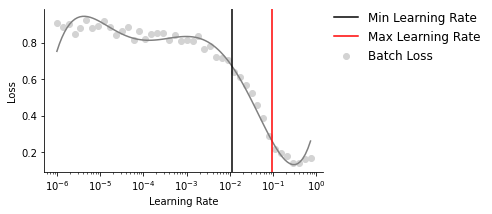

In [6]:
example_rna_model.get_learning_rate_bounds(rna_data)
example_rna_model.trim_learning_rate_bounds(2.5, 1) # The trim function moves the lower and upper bounds in by a factor of 10 from the spline-estimated learning rate values
example_rna_model.plot_learning_rate_bounds(figsize=(5,3))

In [8]:
example_rna_model = mira.topic_model.ExpressionTopicModel(
    exogenous_key='exog_feature',
    endogenous_key='highly_variable',
    seed=586839805,
    num_topics=22,
    decoder_dropout=0.2,
    encoder_dropout=0.06084789416119217,
    num_epochs=37, batch_size=32, beta=0.9138240471577984,
    max_learning_rate=0.04157746477162606,
    min_learning_rate=0.011551766293393191,
).fit(rna_data)

example_rna_model.save('example_rna_model.pth')

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: exog_feature
INFO:mira.adata_interface.topic_model:Using highly-variable genes from col: highly_variable
Epoch 38 done. Recent losses: 6.001e-01 --> 6.003e-01 --> 5.993e-01 --> 5.992e-01 --> 5.991e-01: 100%|██████████| 37/37 [01:55<00:00,  3.11s/it]
INFO:mira.topic_model.base:Moving model to device: cpu


In [ ]:
example_atac_model = mira.topic_model.AccessibilityTopicModel(
    seed=4136248434,
    num_topics=13,
    decoder_dropout=0.2,
    encoder_dropout=0.07451370312651999,
    num_epochs=39, batch_size=32, beta=0.9041965277033556,
    max_learning_rate=0.02638015294961751,
    min_learning_rate=0.006734638401989464,
).fit(atac_data)

example_atac_model.save('example_atac_model.pth')

In [10]:
rna_model = mira.topic_model.ExpressionTopicModel.load('mira-datasets/e18_10X_brain_dataset/e18_mouse_brain_10x_rna_model.pth')
atac_model = mira.topic_model.AccessibilityTopicModel.load('mira-datasets/e18_10X_brain_dataset/e18_mouse_brain_10x_atac_model.pth')

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


In [11]:
rna_model.predict(rna_data)
atac_model.predict(atac_data, batch_size=128)

Predicting latent vars: 100%|██████████| 10/10 [00:00<00:00, 10.03it/s]
INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram
Predicting latent vars: 100%|██████████| 37/37 [00:11<00:00,  3.22it/s]
INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12
INFO:mira.adata_interface.core:Added key to varm: topic_featu

In [12]:
atac_model.get_umap_features(atac_data, box_cox = 0.5)
rna_model.get_umap_features(rna_data, box_cox = 0.5)
rna_data, atac_data = mira.utils.make_joint_representation(rna_data, atac_data)
rna_model.impute(rna_data)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
INFO:mira.adata_interface.utils:4706 out of 4706 cells shared between datasets (100%).
INFO:mira.adata_interface.utils:Key added to obsm: X_joint_umap_features
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
Imputing features: 100%|██████████| 10/10 [00:00<00:00, 307.80it/s]
INFO:mira.adata_interface.core:Added layer: imputed


In [13]:
main_barcodes = pd.read_csv("mira-datasets/e18_10X_brain_dataset/e18_mouse_brain_10x_main_barcodes.csv", index_col=0, header=0, names=["barcodes"])

In [14]:
rna_main = rna_data[list(main_barcodes["barcodes"])]
atac_main = atac_data[list(main_barcodes["barcodes"])]

exp_topic_ordered = [f'topic_{i}' for i in     # included topics, custom order
                     [1, 3, 19, 20, 10, 13, 9, 0, 15, 8, 16, 18, 7, 5, 2, 21, 4, 6, 14, 12]]
acc_topic_ordered = [f'topic_{i}' for i in     # included topics, custom order
                     [11, 5, 6, 2, 8, 7, 0, 9, 10, 1, 12, 4, 3]]

In [15]:
sc.pp.neighbors(rna_main, use_rep='X_joint_umap_features', metric='manhattan')
sc.tl.umap(rna_main, min_dist = 0.3, negative_sample_rate=5)

atac_main.obsm['X_umap'] = rna_main.obsm['X_umap']

In [16]:
# function to flip axes of UMAP
def flip_axes(plot, x, y):
  ax = plot.axes
  for ax_i in ax:
    if x == True:
      ax_i.invert_xaxis()
    if y == True:
      ax_i.invert_yaxis()

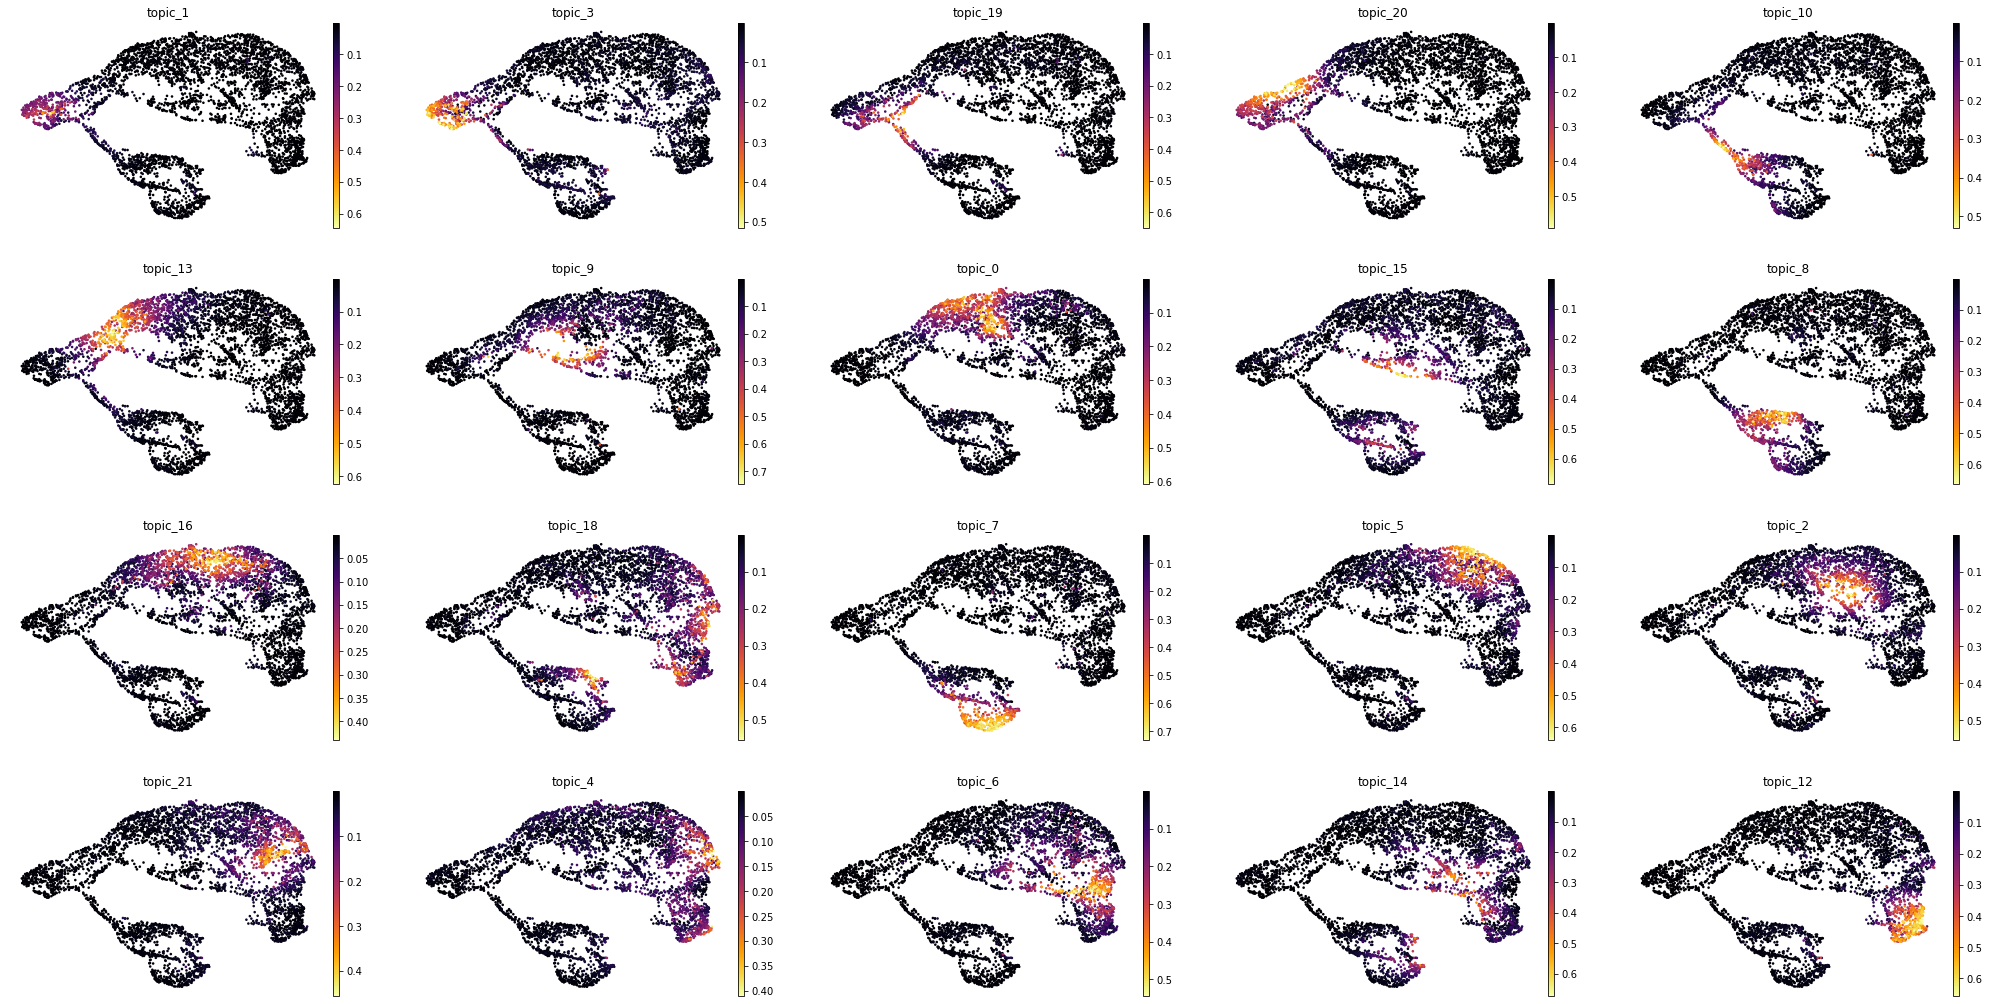

In [17]:
umap = sc.pl.umap(rna_main, color=exp_topic_ordered, layer='imputed',
                  frameon=False, color_map='inferno', ncols=5, return_fig=True)
flip_axes(umap, True, True)

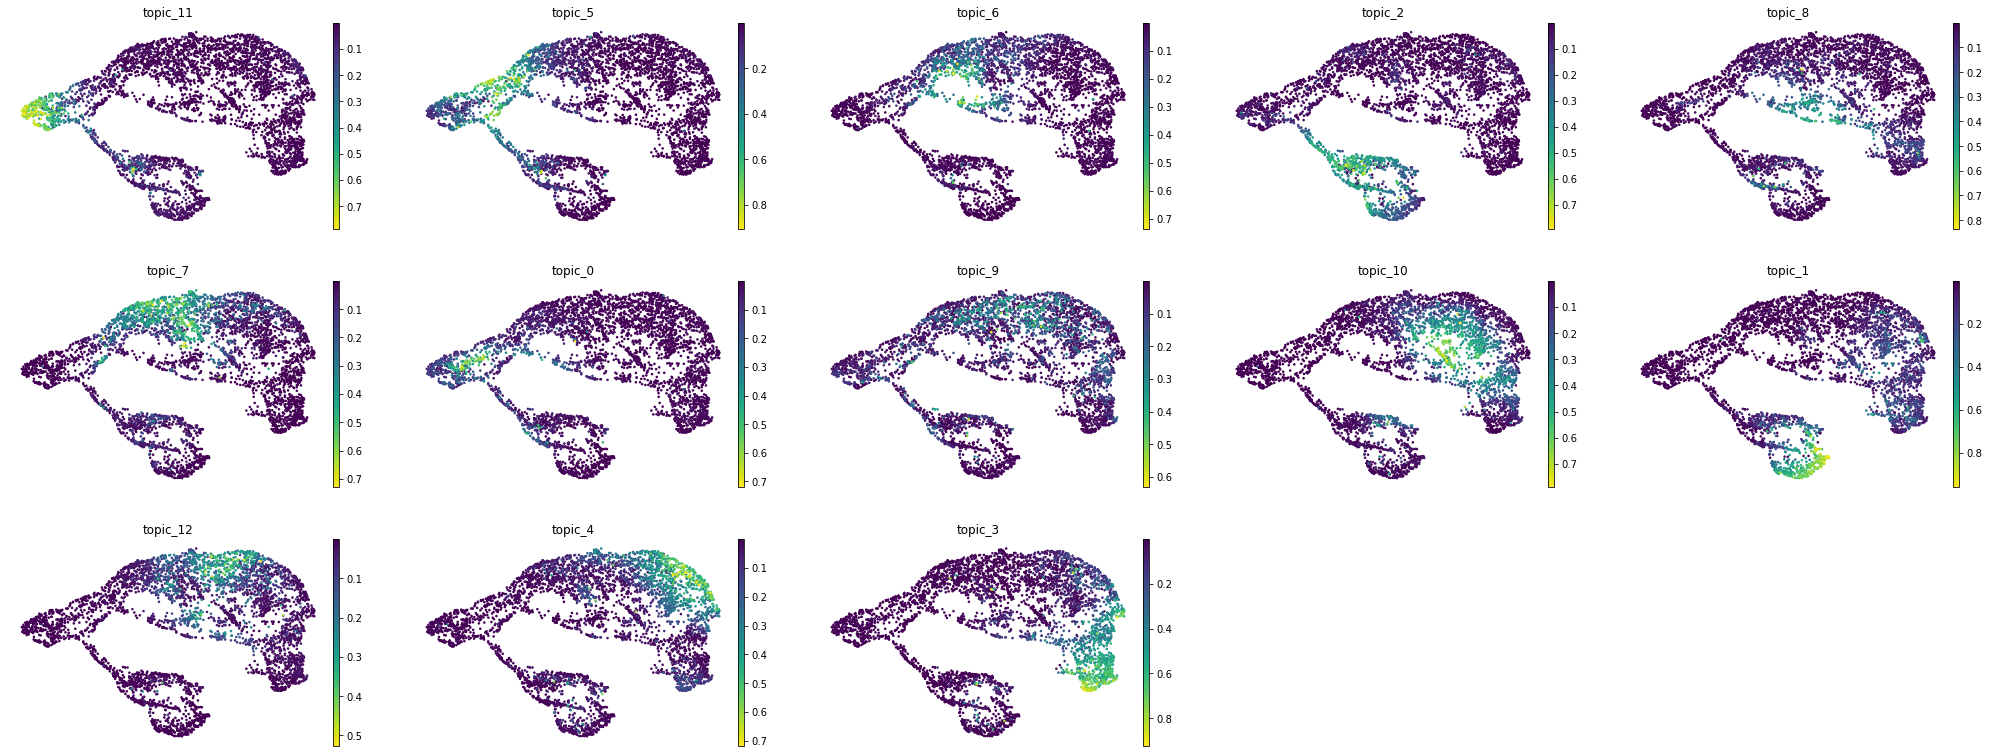

In [18]:
umap = sc.pl.umap(atac_main, color=acc_topic_ordered, layer='imputed',
                     frameon=False, color_map='viridis', ncols=5, return_fig=True)
flip_axes(umap, True, True)

INFO:root:Added key to obsm: X_diffmap, normalized diffmap with 14 components.
INFO:root:Added key to uns: eigen_gap


Recommending 3 diffusion map components.


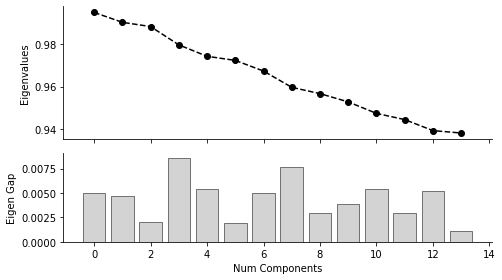

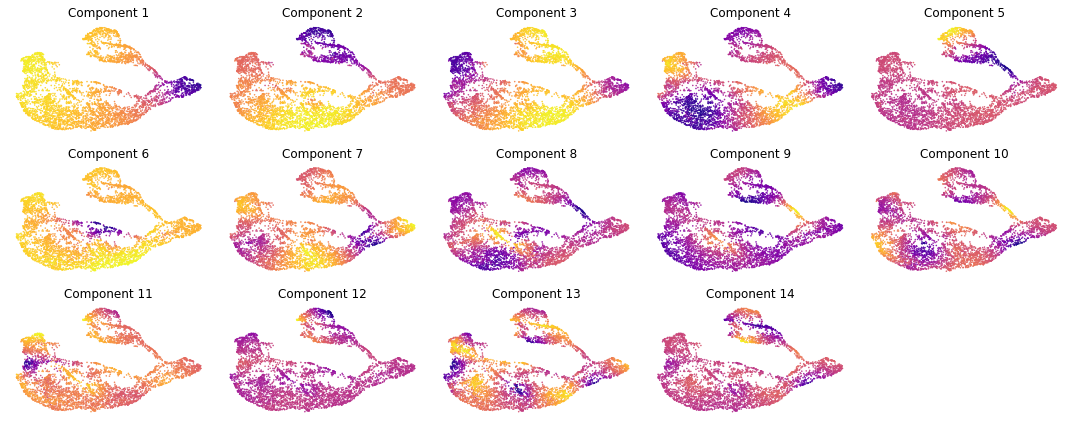

In [19]:
sc.pp.neighbors(rna_main, use_rep='X_joint_umap_features', metric = 'manhattan', n_pcs=None) # calculate a KNN graph from the joint representation
sc.tl.diffmap(rna_main) # denoise the KNN graph by calculating a diffusion map
mira.time.normalize_diffmap(rna_main) # normalize the diffmap dimensions, choose number of dimensions to represent data
mira.pl.plot_eigengap(rna_main)
plt.show()

In [20]:
rna_main.obsm['X_diffmap'] = rna_main.obsm['X_diffmap'][:, :7]
sc.pp.neighbors(rna_main, use_rep='X_diffmap', key_added='X_diffmap', n_neighbors = 30) # calculate another KNN graph, this time in diffusion space
mira.time.get_connected_components(rna_main) # calculate the subgraphs within the data. Lineage inference may only be used on connected groups of cells.
mira.time.get_transport_map(rna_main, start_cell = 3682) # define a stochastic transport map modeling the differentiation
mira.time.get_branch_probabilities(rna_main,
                                   terminal_cells= {"Excitatory": 2483,
                                                    "Astrocyte": 4106,
                                                    "Inhibitory": 2131}) # get probabilities of differentiating to each terminal cell
mira.time.get_tree_structure(rna_main, threshold=2) # identify branching structure of data. Threshold parameter is data-specific.

INFO:mira.pseudotime.pseudotime:Found 1 components of KNN graph.
INFO:mira.adata_interface.core:Added cols to obs: mira_connected_components
INFO:mira.pseudotime.pseudotime:Calculating inter-cell distances ...
INFO:root:Using 1 core. Speed this up by allocating more n_jobs.
Calculating pseudotime: 2247it [00:00, 899036.64it/s]           
INFO:mira.pseudotime.pseudotime:Calculating transport map ...
INFO:mira.adata_interface.pseudotime:Added key to obs: mira_pseudotime
INFO:mira.adata_interface.pseudotime:Added key to obsp: transport_map
INFO:mira.adata_interface.pseudotime:Added key to uns: start_cell
INFO:mira.pseudotime.pseudotime:Simulating random walks ...
INFO:mira.adata_interface.pseudotime:Added key to obsm: branch_probs
INFO:mira.adata_interface.pseudotime:Added key to uns: lineage_names
INFO:mira.adata_interface.core:Added cols to obs: Excitatory_prob
INFO:mira.adata_interface.core:Added cols to obs: Astrocyte_prob
INFO:mira.adata_interface.core:Added cols to obs: Inhibitory_p

In [29]:
acc_topic_prefixed = [f"atac_{topic}" for topic in acc_topic_ordered]
rna_main.obs[acc_topic_prefixed] = atac_main.obs[acc_topic_ordered]

... storing 'mira_connected_components' as categorical
... storing 'tree_states' as categorical


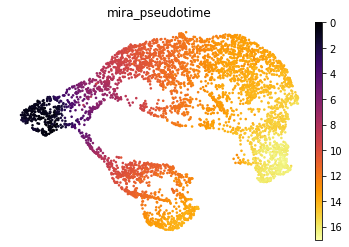

In [30]:
umap = sc.pl.umap(rna_main, color='mira_pseudotime', frameon=False,
           color_map='inferno', return_fig=True)
flip_axes(umap, True, True)

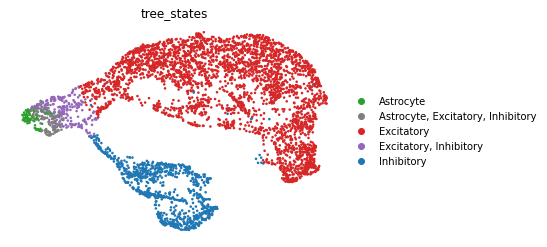

In [31]:
umap = sc.pl.umap(rna_main, color='tree_states', frameon=False, return_fig=True,
                  palette=['tab:green','tab:gray','tab:red','tab:purple','tab:blue'])
flip_axes(umap, True, True)

In [32]:
rna_main

AnnData object with n_obs × n_vars = 4507 × 5351
    obs: 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'test_set', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'mira_connected_components', 'mira_pseudotime', 'Excitatory_prob', 'Astrocyte_prob', 'Inhibitory_prob', 'differentiation_entropy', 'tree_states', 'atac_topic_11', 'atac_topic_5', 'atac_topic_6', 'atac_topic_2', 'atac_topic_8', 'atac_topic_7', 'atac_topic_0', 'atac_topic_9', 'atac_topic_10', 'atac_topic_1', 'atac_topic_12', 'atac_topic_4', 'atac_topic_3'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'exog_feature'
    uns: 'log1p', 'hvg', 

In [37]:
df_celltype = pd.DataFrame(rna_main.obs['tree_states'])

In [38]:
df_celltype.to_csv('/media/data/single_cell/brent10070/E18_Mouse_Brain/celltype.csv', index=True)

In [39]:
df_umap = pd.DataFrame(rna_main.obsm['X_umap'])

In [40]:
df_umap.to_csv('/media/data/single_cell/brent10070/E18_Mouse_Brain/umap.csv', index=True)